<a href="https://colab.research.google.com/github/PedroSalomaoR/reconhecimento-facial-machine-learning-YOLO/blob/main/reconhecimentofacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando bibliotécas e funções

In [1]:
import os
import cv2
import glob
import time
import random
import numpy as np
from pathlib import Path
from typing import Tuple
import tempfile
import shutil
try:
    from google.colab.patches import cv2_imshow
    USE_COLAB = True
except ImportError:
    USE_COLAB = False

Principais configurações


In [2]:
class Config:
    faces_train_dir: str = "data/faces_train"
    faces_val_dir: str = "data/faces_val"
    out_dir: str = "artifacts"

CFG = Config()
Path(CFG.out_dir).mkdir(parents=True, exist_ok=True)



Criando um dataset sintético


In [3]:
def create_synthetic_faces(out_train: str = CFG.faces_train_dir,
                           out_val: str = CFG.faces_val_dir,
                           num_persons: int = 4,
                           images_per_person: int = 8,
                           img_size: Tuple[int, int] = (160, 160),
                           train_ratio: float = 0.8):
    h, w = img_size
    for dataset_dir in [out_train, out_val]:
        Path(dataset_dir).mkdir(parents=True, exist_ok=True)

    for pid in range(num_persons):
        name = f"person_{pid+1}"
        for _ in range(images_per_person):
            target_dir = out_train if random.random() < train_ratio else out_val
            person_dir = Path(target_dir) / name
            person_dir.mkdir(parents=True, exist_ok=True)

            img = np.full((h, w, 3), 255, dtype=np.uint8)
            center = (w//2, h//2)
            radius = int(min(h, w) * 0.32)
            cv2.ellipse(img, center, (radius, int(radius*1.1)), 0, 0, 360, (220,200,180), -1)
            eye_y = center[1] - radius//3
            eye_dx = radius//2
            cv2.circle(img, (center[0]-eye_dx, eye_y), max(2,radius//10), (0,0,0), -1)
            cv2.circle(img, (center[0]+eye_dx, eye_y), max(2,radius//10), (0,0,0), -1)
            cv2.ellipse(img, (center[0], center[1]+radius//4), (radius//3, radius//6), 0,0,180,(0,0,0),2)

            fname = f"{name}_{int(time.time()*1000)}_{random.randint(0,9999)}.jpg"
            cv2.imwrite(str(person_dir / fname), img)

    print(f"[SYNTHETIC] Dataset criado: {out_train} e {out_val}")

Preparar LFW ou fallback sintético

In [4]:
def prepare_lfw_dataset(min_faces_per_person:int=10, resize:float=0.5, train_ratio:float=0.8):
    try:
        from sklearn.datasets import fetch_lfw_people
        lfw = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize, color=True)
        for img, label in zip(lfw.images, lfw.target):
            name = lfw.target_names[label]
            folder = CFG.faces_train_dir if random.random() < train_ratio else CFG.faces_val_dir
            person_dir = Path(folder) / name
            person_dir.mkdir(parents=True, exist_ok=True)
            arr = (img*255).astype(np.uint8) if img.max()<=1.0 else img.astype(np.uint8)
            img_bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
            fname = f"{name}_{int(time.time()*1000)}_{random.randint(0,9999)}.jpg"
            cv2.imwrite(str(person_dir / fname), img_bgr)
        print(f"[LFW] Dataset salvo em {CFG.faces_train_dir} e {CFG.faces_val_dir}.")
    except Exception as e:
        print(f"[LFW] Falha ao carregar LFW ({e}), usando dataset sintético.")
        create_synthetic_faces(num_persons=6, images_per_person=12, img_size=(160,160), train_ratio=train_ratio)

Exibir imagens de treino com bounding box

In [5]:
def show_train_images_with_bboxes(train_dir:str=CFG.faces_train_dir, max_images:int=8):
    img_paths = glob.glob(os.path.join(train_dir,'**','*.jpg'), recursive=True)
    random.shuffle(img_paths)
    for img_path in img_paths[:max_images]:
        img = cv2.imread(img_path)
        name = Path(img_path).parent.name
        h, w, _ = img.shape
        box_size = int(min(h,w)*0.8)
        top_left = ((w-box_size)//2, (h-box_size)//2)
        bottom_right = (top_left[0]+box_size, top_left[1]+box_size)
        cv2.rectangle(img, top_left, bottom_right, (0,0,255), 2)
        cv2.putText(img, name, (top_left[0], top_left[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255),2)
        if USE_COLAB:
            from google.colab.patches import cv2_imshow
            cv2_imshow(img)
        else:
            cv2.imshow('Treino com Bounding Box', img)
            cv2.waitKey(1000)
    if not USE_COLAB:
        cv2.destroyAllWindows()

Teste leve

In [6]:
def run_light_tests():
    print("[TEST] Executando testes leves de I/O e preparação de dataset...")
    tmpdir = tempfile.mkdtemp(prefix="face_pipeline_test_")
    try:
        train = os.path.join(tmpdir, "train")
        val = os.path.join(tmpdir, "val")
        create_synthetic_faces(out_train=train, out_val=val, num_persons=3, images_per_person=5, img_size=(120,120), train_ratio=0.7)
        pairs = glob.glob(os.path.join(train,'**','*.jpg'), recursive=True)
        pairs_val = glob.glob(os.path.join(val,'**','*.jpg'), recursive=True)
        print(f"[TEST] {len(pairs)} imagens de treino, {len(pairs_val)} imagens de validação.")
        print("[TEST] Testes leves concluídos com sucesso.")
    finally:
        shutil.rmtree(tmpdir)

Finalização


[LFW] Dataset salvo em data/faces_train e data/faces_val.
[TEST] Executando testes leves de I/O e preparação de dataset...
[SYNTHETIC] Dataset criado: /tmp/face_pipeline_test_f52_f4qt/train e /tmp/face_pipeline_test_f52_f4qt/val
[TEST] 11 imagens de treino, 4 imagens de validação.
[TEST] Testes leves concluídos com sucesso.


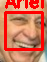

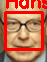

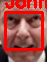

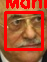

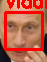

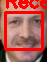

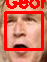

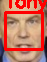

[INFO] Execução finalizada.


In [7]:
if __name__ == "__main__":
    random.seed(42)
    prepare_lfw_dataset(min_faces_per_person=20, resize=0.5, train_ratio=0.8)
    run_light_tests()
    show_train_images_with_bboxes(train_dir=CFG.faces_train_dir, max_images=8)
    print("[INFO] Execução finalizada.")
